<h1> Parameter Tunning 
    
    Look at different steps & batch sizes 
    (4 months of data used)

# Importing libraries:

In [1]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt
import time

# months to evaluate model on
date = 2018090000

# for later use
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import data; fill nan values; split data intro train and test:

In [2]:
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values in the whole data set
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [3]:
from sklearn.preprocessing import MinMaxScaler

# data scaling
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

# Need to process data with spike occurences in the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [5]:
# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data_shade(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# function to cut data set so it can be divisible by the batch_size
def cut_data_shade(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# Prepare of data according to LSTM needs,  create regressor & tune:

In [6]:
# parameters
# steps = 96
n_hidden = 2
units = 100
# batch_size = 96

from sklearn.model_selection import ParameterGrid

# 48 - day; 96 - 2 days; 336 - 1 week
parameters = {'steps': [48, 96, 336],
              'batch_size': [48, 96, 336]}

all_param = ParameterGrid(parameters)

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

for i in range(len(all_param)):
    
    start_time = time.time()
    
    # set parameters right
    steps = all_param[i]['steps']
    batch_size = all_param[i]['batch_size']
    
    # divide features and labels
    X_train = data_train[:, 0:14] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:14] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.15, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    X_train = cut_data(X_train, batch_size)
    y_train = cut_data(y_train, batch_size)
    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)
    X_val = cut_data(X_val, batch_size)
    y_val = cut_data(y_val, batch_size)

    def regressor_tunning(kernel_initializer = 'he_uniform',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        if n_hidden == 0:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = optimizers.RMSprop()
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning()

    # fitting the LSTM to the training set
    model.fit(X_train,
              y_train, 
              batch_size = batch_size, 
              epochs = 100,
              shuffle = False, 
              validation_data = (X_val, y_val))

    # reset states to have suitable predictions
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    
    # Reshaping
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    
    y_pred_list.append(y_pred)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)

    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)
    y_spike_occ = cut_data_shade(y_spike_occ, batch_size)
    
    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)


Epoch 1/100
87/87 [==============================] - 6s 69ms/step - loss: 0.1656 - mse: 0.1656 - mae: 0.2987 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0285
Epoch 2/100
87/87 [==============================] - 5s 62ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1280 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0996
Epoch 3/100
87/87 [==============================] - 5s 63ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0645 - val_loss: 7.8415e-04 - val_mse: 7.8415e-04 - val_mae: 0.0187
Epoch 4/100
87/87 [==============================] - 6s 64ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0386 - val_loss: 8.5004e-04 - val_mse: 8.5004e-04 - val_mae: 0.0200
Epoch 5/100
87/87 [==============================] - 6s 64ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0266 - val_loss: 8.3182e-04 - val_mse: 8.3182e-04 - val_mae: 0.0196
Epoch 6/100
87/87 [==============================] - 6s 68ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0231 - val_loss: 4.9676e-04 - val_mse: 4.9676e-04 - 

87/87 [==============================] - 5s 59ms/step - loss: 8.2318e-04 - mse: 8.2318e-04 - mae: 0.0129 - val_loss: 2.7934e-04 - val_mse: 2.7934e-04 - val_mae: 0.0108
Epoch 93/100
87/87 [==============================] - 5s 60ms/step - loss: 7.8850e-04 - mse: 7.8850e-04 - mae: 0.0124 - val_loss: 3.1517e-04 - val_mse: 3.1517e-04 - val_mae: 0.0111
Epoch 94/100
87/87 [==============================] - 6s 67ms/step - loss: 8.1197e-04 - mse: 8.1197e-04 - mae: 0.0128 - val_loss: 2.9138e-04 - val_mse: 2.9138e-04 - val_mae: 0.0111
Epoch 95/100
87/87 [==============================] - 6s 68ms/step - loss: 8.1042e-04 - mse: 8.1042e-04 - mae: 0.0127 - val_loss: 2.7230e-04 - val_mse: 2.7230e-04 - val_mae: 0.0107
Epoch 96/100
87/87 [==============================] - 6s 68ms/step - loss: 7.5423e-04 - mse: 7.5423e-04 - mae: 0.0121 - val_loss: 2.8280e-04 - val_mse: 2.8280e-04 - val_mae: 0.0109
Epoch 97/100
87/87 [==============================] - 6s 73ms/step - loss: 7.7544e-04 - mse: 7.7544e-04 - ma

Epoch 83/100
86/86 [==============================] - 15s 180ms/step - loss: 8.4834e-04 - mse: 8.4834e-04 - mae: 0.0133 - val_loss: 2.9313e-04 - val_mse: 2.9313e-04 - val_mae: 0.0107
Epoch 84/100
86/86 [==============================] - 14s 158ms/step - loss: 8.1450e-04 - mse: 8.1450e-04 - mae: 0.0131 - val_loss: 2.9117e-04 - val_mse: 2.9117e-04 - val_mae: 0.0109
Epoch 85/100
86/86 [==============================] - 16s 183ms/step - loss: 8.0317e-04 - mse: 8.0317e-04 - mae: 0.0129 - val_loss: 3.4750e-04 - val_mse: 3.4750e-04 - val_mae: 0.0112
Epoch 86/100
86/86 [==============================] - 14s 166ms/step - loss: 8.9621e-04 - mse: 8.9621e-04 - mae: 0.0137 - val_loss: 3.0247e-04 - val_mse: 3.0247e-04 - val_mae: 0.0112
Epoch 87/100
86/86 [==============================] - 15s 172ms/step - loss: 8.4624e-04 - mse: 8.4624e-04 - mae: 0.0132 - val_loss: 3.1749e-04 - val_mse: 3.1749e-04 - val_mae: 0.0109
Epoch 88/100
86/86 [==============================] - 14s 163ms/step - loss: 8.0316e-

81/81 [==============================] - 169s 2s/step - loss: 9.7751e-04 - mse: 9.7751e-04 - mae: 0.0144 - val_loss: 3.2990e-04 - val_mse: 3.2990e-04 - val_mae: 0.0106
Epoch 77/100
81/81 [==============================] - 166s 2s/step - loss: 9.9299e-04 - mse: 9.9299e-04 - mae: 0.0144 - val_loss: 3.0816e-04 - val_mse: 3.0816e-04 - val_mae: 0.0101
Epoch 78/100
81/81 [==============================] - 167s 2s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0147 - val_loss: 2.9557e-04 - val_mse: 2.9557e-04 - val_mae: 0.0095
Epoch 79/100
81/81 [==============================] - 164s 2s/step - loss: 9.8477e-04 - mse: 9.8477e-04 - mae: 0.0146 - val_loss: 2.9331e-04 - val_mse: 2.9331e-04 - val_mae: 0.0093
Epoch 80/100
81/81 [==============================] - 171s 2s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0148 - val_loss: 2.9320e-04 - val_mse: 2.9320e-04 - val_mae: 0.0095
Epoch 81/100
81/81 [==============================] - 164s 2s/step - loss: 9.8095e-04 - mse: 9.8095e-04 - mae: 0.0142 - val_

43/43 [==============================] - 7s 157ms/step - loss: 9.4016e-04 - mse: 9.4016e-04 - mae: 0.0147 - val_loss: 2.7626e-04 - val_mse: 2.7626e-04 - val_mae: 0.0105
Epoch 69/100
43/43 [==============================] - 8s 181ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0148 - val_loss: 2.7486e-04 - val_mse: 2.7486e-04 - val_mae: 0.0105
Epoch 70/100
43/43 [==============================] - 8s 195ms/step - loss: 9.9018e-04 - mse: 9.9018e-04 - mae: 0.0151 - val_loss: 2.7871e-04 - val_mse: 2.7871e-04 - val_mae: 0.0112
Epoch 71/100
43/43 [==============================] - 8s 187ms/step - loss: 9.5905e-04 - mse: 9.5905e-04 - mae: 0.0147 - val_loss: 2.6914e-04 - val_mse: 2.6914e-04 - val_mae: 0.0098
Epoch 72/100
43/43 [==============================] - 8s 180ms/step - loss: 9.6374e-04 - mse: 9.6374e-04 - mae: 0.0144 - val_loss: 2.7510e-04 - val_mse: 2.7510e-04 - val_mae: 0.0108
Epoch 73/100
43/43 [==============================] - 7s 163ms/step - loss: 9.2175e-04 - mse: 9.2175e-04 - mae:

Epoch 14/100
43/43 [==============================] - 16s 371ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0207 - val_loss: 4.6429e-04 - val_mse: 4.6429e-04 - val_mae: 0.0134
Epoch 15/100
43/43 [==============================] - 15s 353ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0202 - val_loss: 4.5593e-04 - val_mse: 4.5593e-04 - val_mae: 0.0137
Epoch 16/100
43/43 [==============================] - 14s 317ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0197 - val_loss: 4.6368e-04 - val_mse: 4.6368e-04 - val_mae: 0.0127
Epoch 17/100
43/43 [==============================] - 15s 354ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0195 - val_loss: 4.4808e-04 - val_mse: 4.4808e-04 - val_mae: 0.0133
Epoch 18/100
43/43 [==============================] - 14s 326ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0192 - val_loss: 4.5078e-04 - val_mse: 4.5078e-04 - val_mae: 0.0128
Epoch 19/100
43/43 [==============================] - 15s 353ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0189 - val_loss: 4

Epoch 60/100
43/43 [==============================] - 16s 376ms/step - loss: 8.9611e-04 - mse: 8.9611e-04 - mae: 0.0143 - val_loss: 2.8969e-04 - val_mse: 2.8969e-04 - val_mae: 0.0099
Epoch 61/100
43/43 [==============================] - 16s 374ms/step - loss: 9.2658e-04 - mse: 9.2658e-04 - mae: 0.0145 - val_loss: 4.4883e-04 - val_mse: 4.4883e-04 - val_mae: 0.0121
Epoch 62/100
43/43 [==============================] - 17s 404ms/step - loss: 9.2300e-04 - mse: 9.2300e-04 - mae: 0.0145 - val_loss: 2.9525e-04 - val_mse: 2.9525e-04 - val_mae: 0.0114
Epoch 63/100
43/43 [==============================] - 17s 393ms/step - loss: 9.0312e-04 - mse: 9.0312e-04 - mae: 0.0145 - val_loss: 3.4212e-04 - val_mse: 3.4212e-04 - val_mae: 0.0109
Epoch 64/100
43/43 [==============================] - 16s 376ms/step - loss: 8.8682e-04 - mse: 8.8682e-04 - mae: 0.0141 - val_loss: 2.8414e-04 - val_mse: 2.8414e-04 - val_mae: 0.0095
Epoch 65/100
43/43 [==============================] - 17s 399ms/step - loss: 9.1118e-

Epoch 53/100
40/40 [==============================] - 61s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0160 - val_loss: 3.0904e-04 - val_mse: 3.0904e-04 - val_mae: 0.0100
Epoch 54/100
40/40 [==============================] - 62s 2s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0157 - val_loss: 3.0214e-04 - val_mse: 3.0214e-04 - val_mae: 0.0096
Epoch 55/100
40/40 [==============================] - 62s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0156 - val_loss: 3.0025e-04 - val_mse: 3.0025e-04 - val_mae: 0.0097
Epoch 56/100
40/40 [==============================] - 63s 2s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0153 - val_loss: 3.1848e-04 - val_mse: 3.1848e-04 - val_mae: 0.0096
Epoch 57/100
40/40 [==============================] - 63s 2s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0157 - val_loss: 3.1588e-04 - val_mse: 3.1588e-04 - val_mae: 0.0097
Epoch 58/100
40/40 [==============================] - 63s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0158 - val_loss: 2.9971e-04 - val_ms

12/12 [==============================] - 4s 303ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0196 - val_loss: 5.8709e-04 - val_mse: 5.8709e-04 - val_mae: 0.0210
Epoch 48/100
12/12 [==============================] - 4s 303ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0196 - val_loss: 5.7130e-04 - val_mse: 5.7130e-04 - val_mae: 0.0206
Epoch 49/100
12/12 [==============================] - 4s 306ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0188 - val_loss: 8.2986e-04 - val_mse: 8.2986e-04 - val_mae: 0.0260
Epoch 50/100
12/12 [==============================] - 4s 301ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0189 - val_loss: 9.3320e-04 - val_mse: 9.3320e-04 - val_mae: 0.0277
Epoch 51/100
12/12 [==============================] - 4s 308ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0195 - val_loss: 5.4117e-04 - val_mse: 5.4117e-04 - val_mae: 0.0198
Epoch 52/100
12/12 [==============================] - 4s 305ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0189 - val_loss: 7.3756e-04 - val_mse

12/12 [==============================] - 4s 311ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0164 - val_loss: 4.4145e-04 - val_mse: 4.4145e-04 - val_mae: 0.0122
Epoch 95/100
12/12 [==============================] - 4s 304ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0155 - val_loss: 6.2992e-04 - val_mse: 6.2992e-04 - val_mae: 0.0227
Epoch 96/100
12/12 [==============================] - 4s 308ms/step - loss: 9.9927e-04 - mse: 9.9927e-04 - mae: 0.0160 - val_loss: 2.9481e-04 - val_mse: 2.9481e-04 - val_mae: 0.0103
Epoch 97/100
12/12 [==============================] - 4s 311ms/step - loss: 9.4182e-04 - mse: 9.4182e-04 - mae: 0.0152 - val_loss: 4.4857e-04 - val_mse: 4.4857e-04 - val_mae: 0.0127
Epoch 98/100
12/12 [==============================] - 4s 320ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0157 - val_loss: 6.3942e-04 - val_mse: 6.3942e-04 - val_mae: 0.0227
Epoch 99/100
12/12 [==============================] - 4s 306ms/step - loss: 9.5717e-04 - mse: 9.5717e-04 - mae: 0.0156 - val_lo

Epoch 89/100
12/12 [==============================] - 8s 692ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0158 - val_loss: 5.1254e-04 - val_mse: 5.1254e-04 - val_mae: 0.0134
Epoch 90/100
12/12 [==============================] - 9s 712ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0160 - val_loss: 4.7499e-04 - val_mse: 4.7499e-04 - val_mae: 0.0188
Epoch 91/100
12/12 [==============================] - 8s 703ms/step - loss: 9.8883e-04 - mse: 9.8883e-04 - mae: 0.0159 - val_loss: 3.2150e-04 - val_mse: 3.2150e-04 - val_mae: 0.0123
Epoch 92/100
12/12 [==============================] - 8s 708ms/step - loss: 9.5057e-04 - mse: 9.5057e-04 - mae: 0.0153 - val_loss: 4.0381e-04 - val_mse: 4.0381e-04 - val_mae: 0.0113
Epoch 93/100
12/12 [==============================] - 8s 659ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0156 - val_loss: 5.4604e-04 - val_mse: 5.4604e-04 - val_mae: 0.0204
Epoch 94/100
12/12 [==============================] - 8s 667ms/step - loss: 9.8687e-04 - mse: 9.8687e-04 - mae: 0.

Epoch 85/100
11/11 [==============================] - 37s 3s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0175 - val_loss: 7.2847e-04 - val_mse: 7.2847e-04 - val_mae: 0.0245
Epoch 86/100
11/11 [==============================] - 37s 3s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0176 - val_loss: 3.8986e-04 - val_mse: 3.8986e-04 - val_mae: 0.0105
Epoch 87/100
11/11 [==============================] - 39s 4s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0169 - val_loss: 3.7283e-04 - val_mse: 3.7283e-04 - val_mae: 0.0116
Epoch 88/100
11/11 [==============================] - 40s 4s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0168 - val_loss: 3.6640e-04 - val_mse: 3.6640e-04 - val_mae: 0.0113
Epoch 89/100
11/11 [==============================] - 38s 3s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0174 - val_loss: 4.1162e-04 - val_mse: 4.1162e-04 - val_mae: 0.0105
Epoch 90/100
11/11 [==============================] - 42s 4s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0173 - val_loss: 7.9469e-04 - val_ms

# Save results into a data frame

In [7]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count})

In [8]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,25.324391,15.263234,33.456947,20.525116,23.873731,14.477657,586.887875
1,24.480897,14.646362,33.941316,21.300044,22.665135,13.615791,1547.358498
2,25.353955,16.485156,35.061034,21.795424,23.163613,15.522893,11555.590111
3,26.339701,15.733421,35.716144,22.200116,24.569426,14.731812,744.465907
4,27.043981,16.596425,36.509330,23.090289,25.262697,15.590608,1652.653026
5,25.976900,15.817331,40.302339,24.773145,22.148860,14.079636,6708.180558
6,46.143802,38.646307,50.675280,39.389288,45.421800,38.534351,409.260412
7,33.170230,26.939392,33.773501,28.273912,33.075959,26.733023,892.720613
8,23.285666,13.415055,34.804623,22.086433,20.208768,11.680780,4188.635720


In [9]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count}, index = all_param)

results.to_csv('Results_LSTM_steps_batch.csv')

y_pred_list = pd.Series(y_pred_list)
y_pred_list.to_csv('Predictions_LSTM_steps_batch.csv')

# Results from architecture with best results in normal regions:

<IPython.core.display.Javascript object>


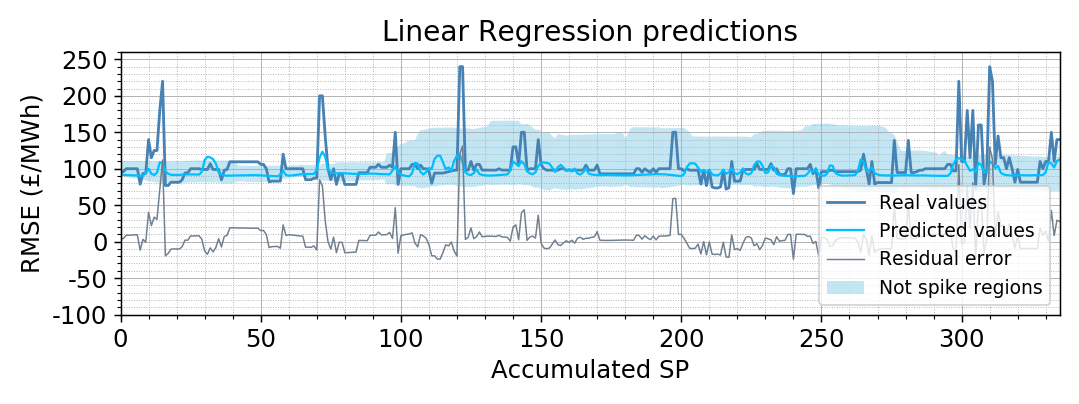

In [25]:
%matplotlib notebook

w_plot = 336 # 3 days
fontsize = 13

y_pred = y_pred_list[8]

Residual = list(y_test) - y_pred

plt.figure(figsize=(8,3))
plt.plot(np.arange(0, (w_plot)), y_test[-w_plot:], label = 'Real values', linewidth = 1.5, color = 'steelblue')
plt.plot(np.arange(0, (w_plot)), y_pred[-w_plot:], label = 'Predicted values', linewidth = 1.2, color= 'deepskyblue')
plt.plot(np.arange(0, (w_plot)), Residual[-w_plot:], label = 'Residual error', linewidth = 0.8, color = 'slategrey')
plt.fill_between(np.arange(0, (w_plot)),  data['spike_lowerlim'][-w_plot:],data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Not spike regions')
plt.xlim(0, w_plot - 1)
plt.ylim(-100, 260)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('Linear Regression predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('LSTM_best_prediction_normal_region.png')

# Results from architecture with the best results in spike regions:

<IPython.core.display.Javascript object>


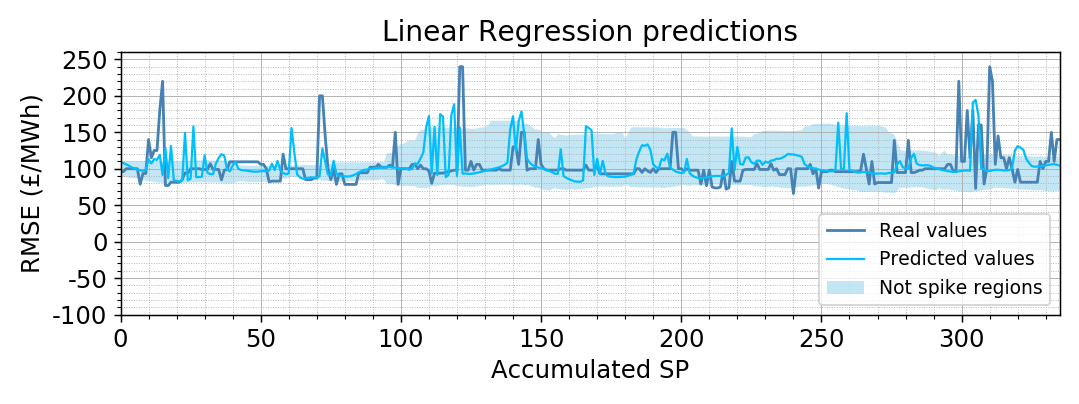

In [29]:
%matplotlib notebook

w_plot = 336 # 3 days
fontsize = 13

y_pred = y_pred_list[0]

#Residual = list(y_test) - y_pred

plt.figure(figsize=(8,3))
plt.plot(np.arange(0, (w_plot)), y_test[-w_plot:], label = 'Real values', linewidth = 1.5, color = 'steelblue')
plt.plot(np.arange(0, (w_plot)), y_pred[-w_plot:], label = 'Predicted values', linewidth = 1.2, color= 'deepskyblue')
#plt.plot(np.arange(0, (w_plot)), Residual[-w_plot:], label = 'Residual error', linewidth = 0.8, color = 'slategrey')
plt.fill_between(np.arange(0, (w_plot)),  data['spike_lowerlim'][-w_plot:],data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Not spike regions')
plt.xlim(0, w_plot - 1)
plt.ylim(-100, 260)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('Linear Regression predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('LSTM_best_prediction_spike_region.png')
